<a href="https://colab.research.google.com/github/smitaforward/Data_Science/blob/master/H2o_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep Env

In [0]:
! apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.10-63ubuntu1~02).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
openjdk version "10.0.2" 2018-07-17
OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4)
OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)


In [0]:
! pip install h2o

    100% |████████████████████████████████| 120.9MB 168kB/s 
  Stored in directory: /root/.cache/pip/wheels/80/d9/27/eba7cef0f0cacb7a31fa32d7086dec0c9726d770593e374e7c
Successfully built h2o


In [0]:
import h2o
h2o.init(max_mem_size='12G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxr4vp6l3
  JVM stdout: /tmp/tmpxr4vp6l3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxr4vp6l3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.5
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_unknownUser_vsnjvv
H2O cluster total nodes:,1
H2O cluster free memory:,12 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


# DATA

In [0]:
# Use local data file or download from GitHub
import os
docker_data_path = "/home/h2o/data/nlp/AmazonReviews.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://s3.amazonaws.com/tomk/h2o-world/megan/AmazonReviews.csv"


# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
#reviews['PositiveReview'] = reviews['Score']>=4
reviews['PositiveReview'] = (reviews['Score'] >= 4).ifelse('1','0')


In [0]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,21791
1,78209


In [0]:
reviews.head(2)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0


# Train Base Model

In [0]:
# find the 80th quantile of time
time_split=reviews['Time'].quantile(prob=[0.8])[1]

In [0]:
reviews['Train']= (reviews['Time'] < time_split).ifelse('Yes', 'No')

In [0]:
reviews.tail(2)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train
B0009JRH1C,AVLEDWHKKIPHA,Good Tea,5,6,248838,Kim,6,1.29704e+09,"A nice big box so you don't have to worry about running out of tea anytime soon. Flavorful, but mild for anytime of day. I would recommend this tea.",1,Yes
B005H6FF3Y,A7WV4HI6C8WRJ,Not fit for human consumption.,1,12,149738,Edward A. Woodward,12,1.33065e+09,"I was very excited when i saw this product, i'm one of those people eager to try anything, and I've had exotic meats before in a number of ways, through friends that hunt I've enjoyed home made dishes made from a wide variety of game animals, and i've had less common animals like ostrich, kangaroo, and aligator that i ordered on like and cooked myself, and i've even had a few of these meats as jerky by other companies. I like the meats of the animals they made these jerkies from, i need to stress that point, because otherwise you may think that is what my problem is. it's not, this product was AWFUL!! these were some of the worst cured meat snacks I've ever had. Is it possible to rate something and give it no stars? because that is what this product deserves. the meat managed somehow to be both bland and surprisingly foul, and coated with enough grease to lubricate an engine. I have tried several of the strips and sticks and found that to be a universal condition. I can only think that the people who wrote the rave reviews for this product did so without tasting it. this is dreadful stuff, suited only for those who simply want the novelty of claiming they ate strange animals and don't care what it tasted like. this meat was not fit for human consumption, in fact, i wouldn't even give it to my dog. I won't be buying anything else from buffalo bob.",0,Yes


In [0]:
train = reviews[reviews['Train']== 'Yes']
valid = reviews[reviews['Train'] == 'No']


In [0]:
reviews.names

['ProductId',
 'UserId',
 'Summary',
 'Score',
 'HelpfulnessDenominator',
 'Id',
 'ProfileName',
 'HelpfulnessNumerator',
 'Time',
 'Text',
 'PositiveReview',
 'Train']

In [0]:
from h2o.estimators import H2OGradientBoostingEstimator

predictors = ['ProductId', 'UserId', 'HelpfulnessDenominator','HelpfulnessNumerator', 'Time']
response='PositiveReview'

In [0]:
gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = 'AUC',
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10,
                                           model_id = 'gbm_baseline.hex')

In [0]:
gbm_baseline.train(x = predictors, y=response, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [0]:
print(f'AUC on Validation Data: {round(gbm_baseline.auc(valid=True),3)}')

AUC on Validation Data: 0.616


In [0]:
gbm_baseline.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45931625811239496: 


,0,1,Error,Rate
0,384.0,4276.0,0.9176,(4276.0/4660.0)
1,128.0,15220.0,0.0083,(128.0/15348.0)
Total,512.0,19496.0,0.2201,(4404.0/20008.0)


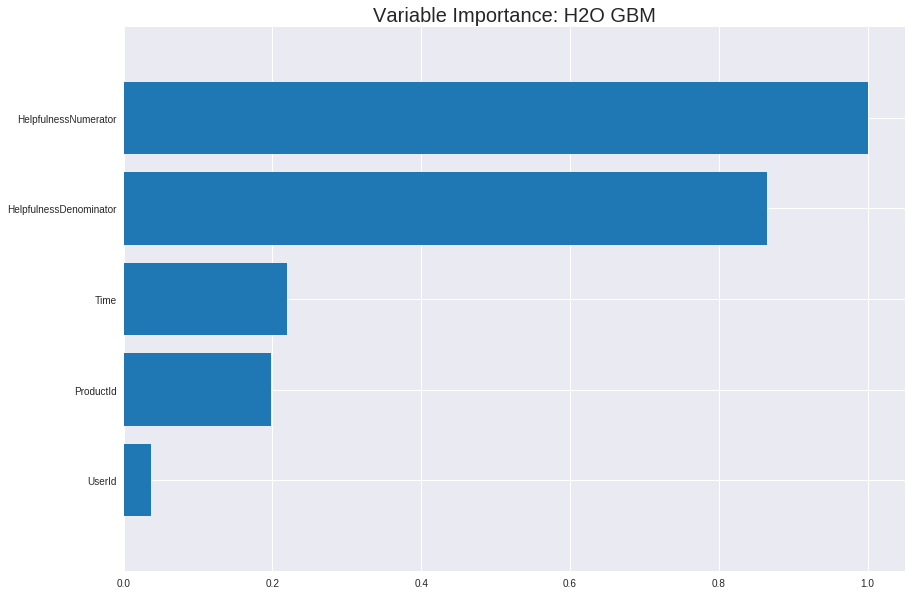

In [0]:
gbm_baseline.varimp_plot()

# Tokenize

In [0]:
# Set Stop Words
# The STOP WORDS we are importing are from the nltk package
import pandas as pd
import os

# Use local data file or download from GitHub
docker_data_path = "/home/h2o/data/nlp/stopwords.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/h2o-world-2017/nlp/stopwords.csv"

STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [0]:
len(STOP_WORDS)

153

In [0]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+") # tokenized by words, which will remove all the other special character, such as "", [], punctuations
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:] # use invet = true to extract non number tokenzies
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:] 
    return tokenized_words

In [0]:
words = tokenize(reviews['Text'])
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


# Train Word2Vec Model

In [0]:
from h2o.estimators.word2vec import H2OWord2vecEstimator

In [0]:
w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [0]:
#w2v_model = h2o.load_model(w2v_path)

In [0]:
w2v_model.find_synonyms('coffee', count = '5')

OrderedDict([('coffe', 0.8011164665222168),
             ('espresso', 0.795991063117981),
             ('coffees', 0.7906833291053772),
             ('expresso', 0.7733843326568604),
             ('brewed', 0.734802782535553)])

In [0]:
# caculate the vec for each review
review_vecs = w2v_model.transform(words, aggregate_method = 'AVERAGE')

In [0]:
# add review with embeddings
ext_reviews = reviews.cbind(review_vecs)

In [0]:
ext_reviews.head(2)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,-0.0334397,0.0587224,-0.0973916,0.0507354,0.00100041,-0.0687384,0.110034,0.030858,-0.0303245,-0.224132,-0.0255798,0.0846478,0.0893458,0.0950163,-0.00138842,-0.110421,-0.203488,0.0835663,-0.0341124,0.00538144,-0.0647419,0.164127,-0.035758,-0.040013,-0.0330751,0.106238,0.0886508,0.111887,0.04447,0.17318,-0.00590384,-0.14619,-0.0317761,0.0623553,-0.127708,0.00689686,0.117939,0.0132855,-0.00360485,0.0650234,0.233051,-0.0156746,-0.0760735,0.258833,0.219453,0.142825,0.0470135,0.0386686,-0.109914,0.110689,-0.00866727,-0.0923441,0.133245,-0.00116396,-0.107254,-0.165806,0.0898597,-0.0226412,0.0532929,-0.0255545,-0.170299,-0.00752662,0.10511,-0.0986587,-0.0628334,0.0207825,-0.0980293,0.0445809,-0.152882,-0.150627,0.0660375,0.0367726,0.1755,0.0547301,0.139016,0.0138052,0.0942586,-0.0771686,0.19868,-0.0902037,0.124137,0.0109686,0.151732,-0.0246483,0.0220815,0.0760319,-0.129161,0.0555044,0.0485086,0.15101,-0.0095916,0.214063,-0.00148241,-0.0495808,-0.136553,-0.0988832,-0.0712226,0.0317462,-0.0840614,0.158959
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,Yes,0.083247,0.102869,0.0455119,-0.0526213,0.153833,-0.152002,-0.0174297,-0.00895996,-0.235187,-0.171868,-0.264151,-0.0393934,0.130923,-0.108746,-0.00239468,0.000110046,-0.0646377,0.0374242,-0.207679,-0.0394262,-0.0224235,0.133269,0.0428463,-0.00883173,0.0549509,0.13223,0.102811,0.0602145,-0.0868577,0.066324,-0.0211561,0.0777884,-0.0484114,0.112608,0.0312672,0.0404489,-0.0416478,0.129834,-0.189087,-0.147081,-0.0568603,0.0258648,-0.0515194,0.174433,0.0907776,0.229658,-0.0600743,0.0601609,-0.00484006,0.0784584,0.144101,-0.048168,0.122465,-0.0866785,0.00855735,0.160046,0.0777081,-0.00017756,0.135043,0.0919474,-0.0604595,0.113629,-0.0672977,-0.100793,-0.159366,-0.000354876,-0.0724062,0.0981881,0.0435634,-0.0215086,0.0861978,-0.0452177,0.0862949,-0.0894611,0.131223,0.041581,-0.0409549,0.0935415,0.146042,-0.0317286,0.0370589,-0.210835,0.068625,-0.00252465,0.000591666,0.163246,-0.0895924,0.080304,0.115315,-0.0533618,-0.109371,0.0403049,0.149495,-0.0255583,-0.152807,-0.137803,-0.136431,0.078818,0.114668,0.0376616


#Train GBM with embeddings

In [0]:
ext_train = ext_reviews[ext_reviews['Train'] == 'Yes']
ext_test = ext_reviews[ext_reviews['Train'] == 'No']

In [0]:
predictors = ['ProductId', 'UserId', 'HelpfulnessDenominator','HelpfulnessNumerator', 'Time'] + review_vecs.names
response = 'PositiveReview'

In [0]:
gbm_embeddings = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_embeddings.hex"
                                             )
gbm_embeddings.train(x = predictors, y = response, 
                   training_frame = ext_train, validation_frame = ext_test
                  )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [0]:
print(f'AUC on Validation Data: {round(gbm_embeddings.auc(valid=True),3)}')

AUC on Validation Data: 0.875


In [0]:
gbm_embeddings.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5549387872837458: 


,0,1,Error,Rate
0,2046.0,2614.0,0.5609,(2614.0/4660.0)
1,547.0,14801.0,0.0356,(547.0/15348.0)
Total,2593.0,17415.0,0.158,(3161.0/20008.0)


In [0]:
gbm_embeddings.accuracy(valid = True)

[[0.5754513906985252, 0.8429128348660536]]

In [0]:
gbm_embeddings.mcc(valid = True)

NameError: ignored

In [0]:
gbm_embeddings.F0point5()

[[0.7490719533858927, 0.9246686785162552]]

# Adding Summary

In [0]:
summary_words = tokenize(reviews['Summary'].ascharacter())

In [0]:
summary_vecs = w2v_model.transform(summary_words, aggregate_method = 'AVERAGE')
summary_vecs.names = ['summary_'+s for s in summary_vecs.names]
ext_reviews = ext_reviews.cbind(summary_vecs)

In [0]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]
predictors = predictors + summary_vecs.names


In [0]:
response = 'PositiveReview'

In [0]:
from h2o.estimators import H2OGradientBoostingEstimator

gbm_plus_summary = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_plus_summary.hex"
                                             )
gbm_plus_summary.train(x = predictors, y = response, 
                       training_frame = ext_train, validation_frame = ext_test
                      )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [0]:
print(f'AUC on Validation Data: {round(gbm_plus_summary.auc(valid=True),3)}')

AUC on Validation Data: 0.912


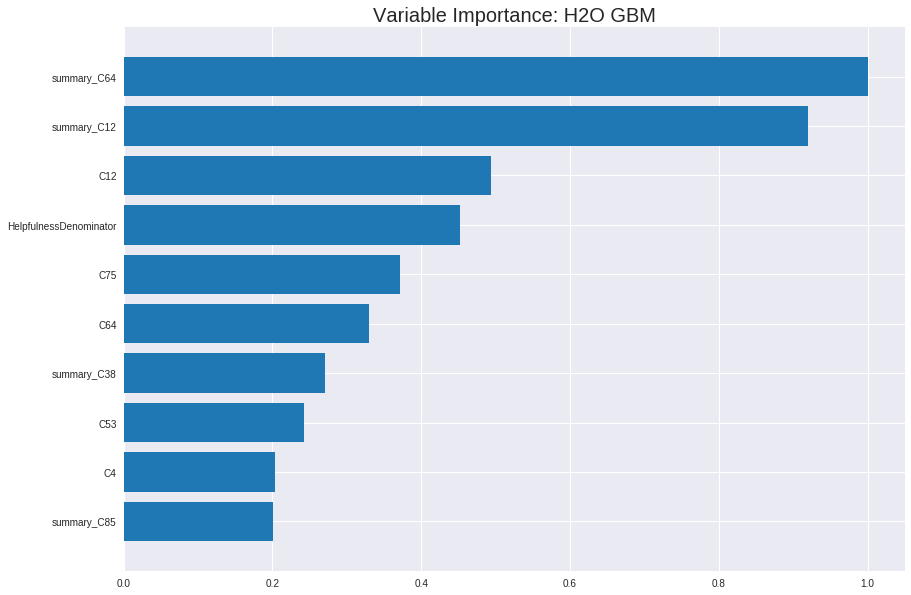

In [0]:
gbm_plus_summary.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


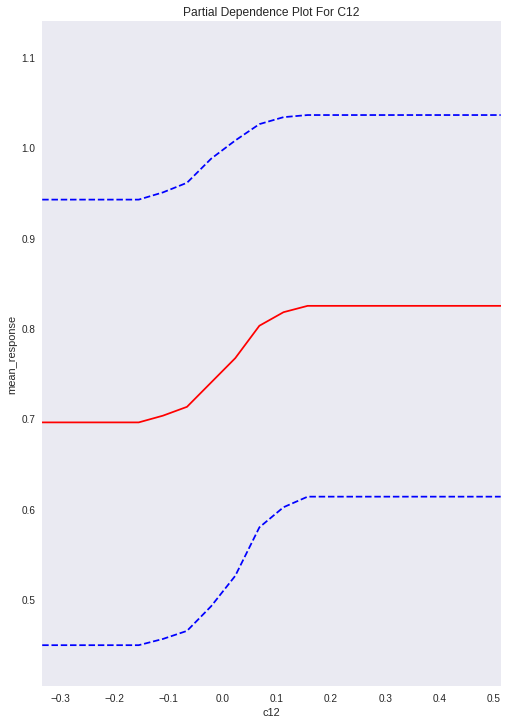

In [0]:
pdp_word_vecs = gbm_plus_summary.partial_plot(data = ext_train, cols = ['C12'])

In [0]:
# Get Word Embeddings per Word
unique_words = summary_words.asfactor().unique().ascharacter()
unique_words.col_names = ["Word"]
word_embeddings = w2v_model.transform(unique_words, aggregate_method="None")
word_embeddings = unique_words.cbind(word_embeddings)
word_embeddings = word_embeddings[~(word_embeddings["C1"].isna())]

In [0]:
word_embeddings

Word,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
aa,0.029092,-0.117329,0.0537625,-0.0697117,0.287874,-0.00254658,0.210048,-0.136762,0.0427679,-0.334558,-0.355636,0.579245,-0.495021,0.270712,-0.0687201,-0.730787,-0.0170917,0.35515,-0.0558159,-0.259497,0.188917,-0.0307768,-0.17509,-0.177578,0.458032,0.0366684,0.0551966,0.101793,0.0659445,-0.361489,-0.480904,-0.0313347,-0.0191771,-0.196597,-0.0757096,0.306963,-0.100564,-0.559201,0.0258643,-0.0533983,-0.283671,-0.273267,-0.179011,-0.312378,-0.183994,0.0770409,-0.156881,-0.127337,-0.0677455,0.21665,0.201273,-0.607145,0.0708613,0.294312,-0.431302,-0.381131,0.0548497,-0.0192432,0.336144,0.385707,-0.165109,-0.213158,-0.0669555,-0.0242088,-0.1039,-0.11178,0.160233,0.016812,0.409889,0.266545,0.691305,-0.207976,-0.102854,-0.0932306,-0.00126054,-0.0603053,0.548074,-0.196542,-0.409358,-0.0258621,0.175579,-0.312181,0.280491,-0.350192,0.0191343,0.312428,-0.0828037,0.172727,-0.375991,-0.130456,0.0738062,0.529666,-0.268026,-0.079465,-0.571229,-0.716438,-0.343874,0.0314978,0.260141,0.143972
aaa,-0.124209,0.145792,-0.156906,0.0116735,-0.0366009,-0.25514,0.00987346,-0.131123,-0.3346,-0.16908,-0.0535209,0.096909,-0.0220011,0.0326328,-0.0421776,-0.212571,0.160064,0.0644105,-0.186383,-0.136889,0.19961,0.115175,0.0388524,0.0227902,0.126286,0.212425,0.145658,0.179555,-0.124992,0.210767,0.0814623,-0.0770555,0.00265771,0.0453787,0.0836823,-0.0937575,0.280179,-0.00510491,0.237304,-0.0196796,0.139403,-0.150945,-0.0181001,0.158317,0.162923,0.0970619,-0.113827,0.0362514,-0.151963,0.107428,-0.0440289,0.31353,0.0666288,0.128978,-0.0464596,-0.101648,0.0461971,0.0256168,0.21315,0.127023,-0.0988737,0.130559,0.0674882,0.0183614,-0.154388,-0.105995,-0.278653,0.0319618,-0.0822952,-0.118171,0.0340789,-0.11196,-0.0186627,-0.133128,-0.0841192,0.156409,-0.110417,-0.126851,0.0272573,0.228992,0.207671,0.2134,-0.114773,0.0794591,0.124394,-0.0999802,-0.283893,0.0966613,0.0460222,0.158783,-0.142605,0.208611,-0.0704097,-0.127221,-0.303552,-0.190036,-0.00335812,0.145233,0.0312736,-0.117551
aaah,-0.212944,0.275176,-0.00254719,-0.122985,0.137706,-0.0624594,-0.00987577,-0.0609369,-0.287903,-0.106259,-0.147927,0.0985058,0.155889,0.00838968,-0.139703,-0.0790587,-0.150657,0.0427222,-0.331432,-0.00552118,-0.123646,0.094539,-0.085097,-0.0415384,0.193869,-0.143504,0.182849,0.108122,-0.0124985,0.286507,0.0846775,0.329579,0.343261,-0.0786061,-0.113295,-0.0128741,0.0113414,-0.0486632,0.0377394,-0.188668,0.0552211,-0.0587902,-0.0689597,0.231622,0.105551,0.0631539,0.12082,0.061934,0.056726,0.0948357,0.0269059,-0.120303,0.104962,0.0956343,0.0393345,0.18845,-0.0920131,0.0556854,0.0207604,0.235515,-0.0942533,-0.0359505,0.0574809,0.0321417,0.0249149,0.127077,-0.209047,0.00032689,-0.0887268,0.0710756,0.0966258,-0.069888,0.191039,-0.142279,0.201809,0.0805401,0.0762053,-0.327359,-0.105065,0.0295985,-0.0364042,-0.103658,-0.00322328,0.0340764,0.205072,0.0324688,-0.31178,-0.0642578,0.21138,-0.185209,0.0263075,0.104409,0.183577,-0.0211353,-0.314838,-0.115686,-0.0212397,0.074265,0.0164078,-0.0275845
aacute,-0.0793622,0.127803,0.147367,-0.19156,-0.107474,0.0218987,-0.00295859,-0.106011,0.193867,-0.134016,0.0805893,-0.116901,-0.12396,-0.159412,0.0558042,0.0856956,0.56071,-0.230821,-0.419845,-0.252627,-0.319596,0.237918,0.0261933,-0.350931,0.210937,-0.113507,0.266292,0.0786942,-0.277101,-0.247451,-0.0960284,0.460362,0.209922,0.313798,0.17598,-0.153172,-0.421101,-0.335617,-0.0847707,-0.0349524,0.527783,-0.397779,-0.129655,-0.245226,0.0620601,0.204425,-0.198245,0.0823046,0.0763633,0.130602,0.110459,-0.0854858,0.244522,-0.152805,-0.483799,0.107812,-0.109976,0.117021,-0.0596762,0.171777,-0.0656986,0.143282,0.388564,0

TypeError: ignored

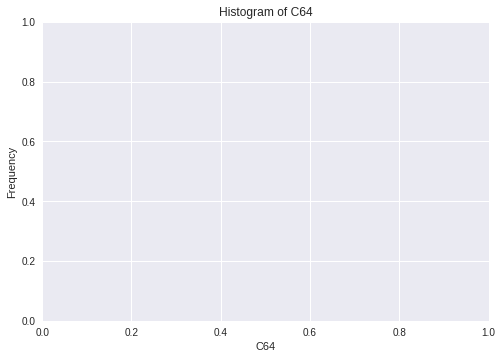

In [0]:
word_embeddings['C64'].hist()

In [0]:
low_c64_words = word_embeddings[word_embeddings["C64"] < -0.8]
low_c64_words[["Word", "C64"]].head(15)

Word,C64
biodegradable,-0.850931
bisphenol,-0.898839
bowels,-0.907133
bpa,-0.811818
buckwheat,-1.12285
bulldog,-0.867981
clusters,-0.884484
digesting,-0.803601
eco,-0.855959
engineered,-0.862782


# Predict on New Reviews

In [0]:
def predict(reviews, w2v, gbm):
    
    words = tokenize(reviews["Text"].ascharacter())
    reviews_vec = w2v.transform(words, aggregate_method="AVERAGE")
    
    summary_words = tokenize(reviews["Summary"].ascharacter())
    summary_vec = w2v.transform(summary_words, aggregate_method="AVERAGE")
    
    model_data = reviews.cbind(reviews_vec).cbind(summary_vec)
    print(gbm.predict(model_data))


In [52]:
good_review = h2o.H2OFrame([["B000EQT574", "AISQLBDGS2KXR", 1, 1, 1263340800, 
                             "Delicious",
                             "These chips are delicious. Salty sweet with a hint of spice. I have no idea how Tamari is supposed to taste, but these chips are awesome. I just finished an entire bag in one day!"]])

good_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [53]:
bad_review = h2o.H2OFrame([["B003BJZMSM", "A2JBZHQVQF7MV0", 1, 2, 1274832000, 
                            "Pretty tasteless",
                            "Quite tasteless and they make you order so many. I am stuck with 12 bags of this tasteless stuff. I am not ordering large amounts of anything from Amazon again. So often I don't like it and I am stuck with so much on hand."]])

bad_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [56]:
# Predict!
print("Good Review: ")
print(predict(good_review, w2v_model, gbm_plus_summary))

print("Bad Review: ")
print(predict(bad_review, w2v_model, gbm_plus_summary))

Good Review: 
gbm prediction progress: |████████████████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C1': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C2': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C3': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C4': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C5': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C6': substit

predict,p0,p1
1,0.356042,0.643958



None
Bad Review: 
gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.735046,0.264954



None


In [0]:
h2o.cluster().shutdown()

## About the Tokenize function 

In [0]:
test = 'My 2000, a two [] Corgis "were" thoroughly spoiled by my late husband  (I spent a year and a half dieting them down a combined total of 25 pounds!)'
test = h2o.H2OFrame.from_python({'String': test}).ascharacter()


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
test

String
"My 2000, a two [] Corgis ""were"" thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)"


In [0]:
tokenized_lower = test.tokenize('\\W+').tolower()
tokenized_lower, len(tokenized_lower)

C1
my
2000
a
two
corgis
were
thoroughly
spoiled
by
my


(, 29)

In [0]:
tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >=2)|tokenized_lower.isna()]
tokenized_filtered, len(tokenized_filtered)

C1
my
2000
two
corgis
were
thoroughly
spoiled
by
my
late


(, 24)

In [0]:
tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]

In [0]:
tokenized_words, len(tokenized_words)

C1
my
two
corgis
were
thoroughly
spoiled
by
my
late
husband


(, 22)

In [0]:
tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]

In [0]:
tokenized_words, len(tokenized_words)

C1
two
corgis
thoroughly
spoiled
late
husband
spent
year
half
dieting


(, 22)